<a href="https://colab.research.google.com/github/googspell/pproject3/blob/main/a_b_ver_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import norm
from tqdm.auto import tqdm
from statsmodels.stats.power import tt_ind_solve_power
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import random
from random import shuffle
import scipy.stats as stats
import pylab
import scipy.stats as stats
import statsmodels.stats.api as sms
from tqdm.notebook import tqdm
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from sklearn.model_selection import train_test_split
import math

#Кратко про A/B

Планирование эксперимента:

    выбираем и фиксируем метрики;

    формулируем гипотезу H0, альтернативную и выбираем MDE;

    выбираем способ подведения итогов;

    определяем alpha и beta, размер выборки и MDE;

    оптимизируем размер выборки.

Подготовка групп:

    разбиваем клиентов на группы;

    проводим стратификацию, если она возможна;

    замораживаем клиентов, участвующих в кампании (контрольная и тестовая группы).

Запуск эксперимента:

    проверяем статус факта воздействия;

    проверяем, что объекты из контрольной группы были без воздействия;

    контролируем заморозку клиентов;

    уточняем, как замораживается глобальная контрольная группа (если планируется ее учет в анализе).

Анализ результатов:

    подготавливаем данные;

    анализируем результаты эксперимента.

#Загрузка данных

In [108]:
#download_data
! gdown --id 1d4dKVSWkM5krXxRAYFfpsjfrKXsvxC09
df = pd.read_csv('data_sample.csv')
df

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1d4dKVSWkM5krXxRAYFfpsjfrKXsvxC09
To: /content/data_sample.csv
100% 222M/222M [00:01<00:00, 139MB/s]


,client_id,metric_0,metric_1,cluster
0,-2917156731031764456,177.886667,179.22000,-6531971287207578528
1,-306818816989293400,180.000000,175.00000,7211711116472990198
2,-1872005487286263859,180.000000,175.00000,-6531971287207578528
3,-5945540625927146720,181.000000,174.17600,3679653954144948413
4,4772133492388554009,159.960000,160.00000,3679653954144948413
...,...,...,...,...
3693379,-6030660957351469840,190.000000,199.91000,-7957617277778039593
3693380,-2479951720758887163,175.873333,179.71000,7211711116472990198
3693381,-9020186507018426629,165.540000,170.27750,-7957617277778039593
3693382,-5655608610769659125,172.670000,173.19200,-7957617277778039593


# Распределение средних
Для проведения теста необходимо выяснить распределение среднего. Распределение среднего покажет каким методом оценки теста лучше воспользоваться. Для этого построим гистограмму и QQ

<Axes: >

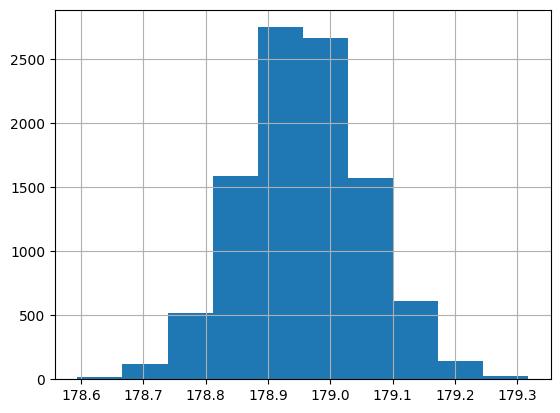

In [ ]:
pd.Series([df['metric_0'].sample(30000,replace=True).mean() for _ in range(10000)]).hist()

Видим, что средние распредлены нормально т.е "колокообразно"

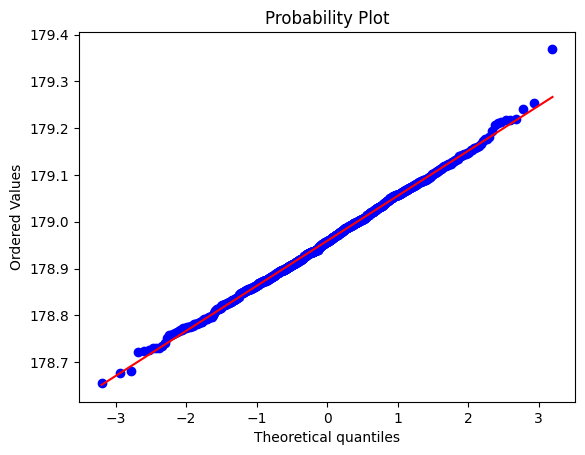

In [ ]:
d = pd.Series([df['metric_0'].sample(30000,replace=True).mean() for _ in range(1000)])
stats.probplot(d, dist="norm", plot=pylab)
pylab.show()

Видим что большая часть средних на линии

Соотвественно средние распределены нормально и выполняються условия для проведения t  -testa

# A/A тестирование

Перед проведением a/b теста необходимо провести a/a тест и убедится в том, что различий между группа a/b нет различий. "Мы планируем дать скидку части пользователям и посмотреть среднее и нам нужно убедиться в том,что нет различий в средних которым планируем дать скидку и которым не планируем".
Проведение a/a теста покажет верно ли выбран тест или наличие разницы средними в контрольной группе. А именно распределение p value должно быть равномерным.
Если нулевая гипотиза верна то распределение p value должно быть равномерным. H0 - разницы между группами нет,выборки из одного распредления.

In [ ]:
p_values = []
variations_rs = []

n = 10000
for _ in tqdm(range(n)):
   sampled = np.random.choice(df['metric_0'].values, (10_000, 2), replace = True)
   A = sampled[:, 0]
   B = sampled[:, 1]

   variations_rs.append(np.var(A))
   _, p_value = ttest_ind(A, B, alternative = 'greater')
   p_values.append(p_value)


  0%|          | 0/10000 [00:00<?, ?it/s]

<Axes: ylabel='Count'>

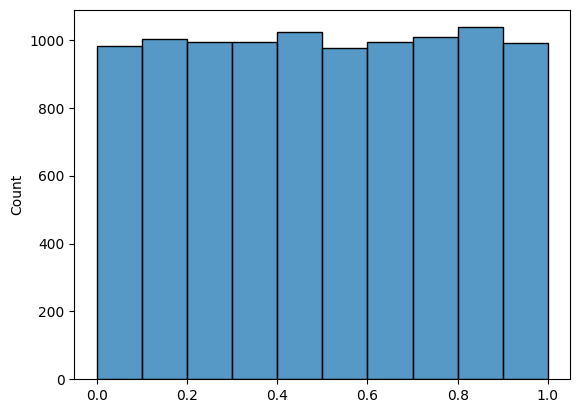

In [ ]:
sns.histplot(p_values, bins = 10)

#Подсчет длительности и установка параметров теста


In [ ]:
mean_value = df['metric_0'].mean()
std_value  = df['metric_0'].std()
eff=1.03
results = tt_ind_solve_power(
                    effect_size=mean_value*(eff-1)/std_value,
                   alpha=0.05,
                   power=0.8,
                   nobs1=None,
                   ratio=1)
results

161.88297530642734

Хотим зафиксировать эффект 3%.

alpha=0.05 - вероятность отвергнуть нулевую гипотезу,когда она верна.

power=0.8 - вероятность отклонить нулевую гипотизу при условии ее не верности.Грубо говорят показывает сколько % детектит наш тест p value < (0.05). В 80% случае когда нулевая гипотиза не верна мы ее отклоним.

Перед проведением эксперимента попробуем снизить дисперсию наших выборок. Зачем снижать дисперсию и что это дает? Дисперсия показывает насколько данные внутренне разбросаны.Соотвественно смещают оценку среднего,снижают MDE(минимальный детектируем эффект который признаеться значимым при заданных параметрах),что приводит к увеличению длительности экспермента(нам нужно набрать больше данных),и снижению чувствительности теста. Существует 2 распостраненных способа снижения дисперсии - стратификация и CUPED.

# Стратификация

В основе этого метода лежит разбиение всех наблюдений на независимые страты (группы) и использование выборочного стратифицированного среднего вместо обычного выборочного среднего.

-выделяем кластеры

-сэмплируем из кластеров

In [ ]:
p_values = []
variations_srs = []
for i in range(1000):
    if (i % 50) == 0:
        print(i)

    clients_A = df.groupby('cluster', group_keys=False).apply(lambda x: x.sample(int(math.ceil(10_000*len(x)/len(df))))).sample(frac=1)
    clients_B = df.loc[list(set(df.index) - set(clients_A.index))].groupby('cluster', group_keys=False).apply(lambda x: x.sample(int(math.ceil(10_000*len(x)/len(df))))).sample(frac=1)
    A = clients_A['metric_0'].values
    B = clients_B['metric_0'].values
    variations_srs.append(np.var(A))
    _, p_value = ttest_ind(A, B, alternative = 'greater')
    p_values.append(p_value)

0
50
100
150
200
250
300
350
400


<Axes: ylabel='Count'>

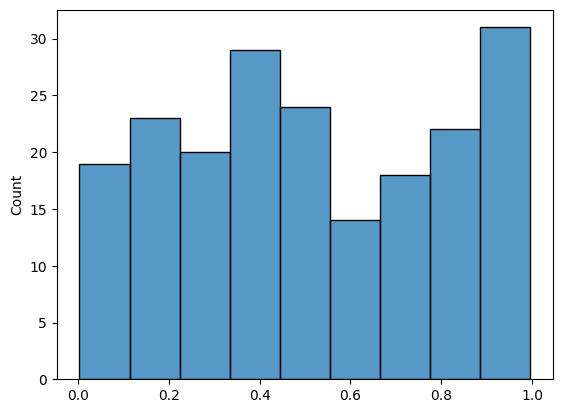

In [ ]:
sns.histplot(p_values)

p-value условно равномерное тест работает(нужно больше повторений)

In [ ]:
#дисперсия
print(np.mean(variations_rs))
print(np.mean(variations_srs))

295.3649233406128
291.46822613172355


<Axes: ylabel='Count'>

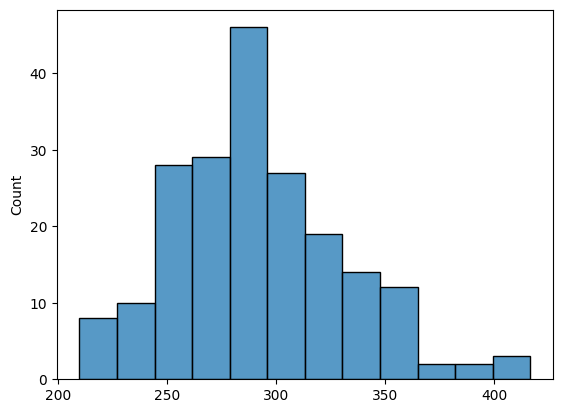

In [ ]:
sns.histplot(variations_srs)

<Axes: ylabel='Count'>

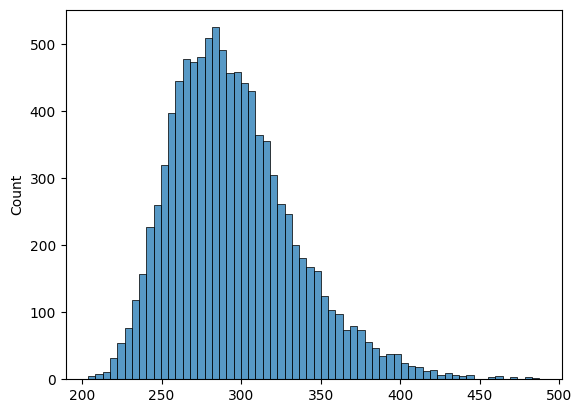

In [ ]:
sns.histplot(variations_rs)

Дисперсия снизилась незначительно

# CUPED

## Расчет thetta

cuped - часть дисперсии обьясняется нововведение а оставшася часть факторами не зависящими от нововедения
Хcuped = х(старая метрика) - коэфициент тета * ковариату Y
Тета = ковариация(х,y) / дисперсию y

Ковариата = метрика за прошлый период,предсказанная метрика.

In [ ]:
np.random.seed(1)
sampled = np.random.choice(df.index.values, (162, 2), replace = True)

In [ ]:
metric_current = df['metric_1'].values
metric_past = df['metric_0'].values
covariance_matrix = np.cov(metric_current, metric_past)
covariance = covariance_matrix[0][1]
metric_past_var = covariance_matrix[1][1]
thetta1 = covariance / metric_past_var
print(thetta1)

### cov = np.cov(old_data, new_data, ddof=1)[0, 1]     theta = cov / np.var(old_data, ddof=1)

0.7568875708035889


In [ ]:
metric_current_A = df[df.index.isin(sampled[:, 0])]['metric_1'].values
metric_past_A = df[df.index.isin(sampled[:, 0])]['metric_0'].values

metric_current_B = df[df.index.isin(sampled[:, 1])]['metric_1'].values
metric_past_B = df[df.index.isin(sampled[:, 1])]['metric_0'].values

thetta2 = np.cov(metric_current_A - metric_current_B, metric_past_A - metric_past_B)[0][1]/ np.var(metric_past_A - metric_past_B)
print(thetta2)

0.7556102665144565


In [ ]:
old_data = df[df.index.isin(sampled[:, 0])]['metric_0'].values
new_data = df[df.index.isin(sampled[:, 0])]['metric_1'].values
cov = np.cov(old_data, new_data, ddof=1)[0, 1]
theta3 = cov / np.var(old_data, ddof=1)
print(theta3)

0.6846862495923627


In [ ]:
cov_X_Y = np.cov(df['metric_0'],df['metric_1'].values,ddof=1)[0, 1]
var_X = np.var(df['metric_0'], ddof=1)
corr_X_Y = np.corrcoef(df['metric_0'], df['metric_1'].values)[0,1]
theta4 = cov_X_Y / var_X
print(theta4)

0.7568875708035858


Есть несколько разновидностей расчеты thetha

В данном случае мы в качестве ковариаты мы выбрали ту же самую метрику но за пред.период. Считаем тету как ковариацию между текущим и прошлым значеним/дисперсию прошлую

## Расчет CUPED метрики и проведение стат.теста


In [ ]:
#часть пользователей которым условно не дали скидку
metric_current_A = df[df.index.isin(sampled[:, 0])]['metric_1'].values
metric_past_A = df[df.index.isin(sampled[:, 0])]['metric_0'].values
metric_cuped_A = metric_current_A - thetta2 * metric_past_A
#metric_cuped_A = metric_current_A - thetta2 * (metric_past_A - np.mean(metric_past_A))
# Y = new_data - theta * (old_data.values - np.mean(old_data.values))
#metric_cuped_B = metric_current_B - thetta2 * metric_past_B + thetta2 * np.mean(metric_past_B)

In [ ]:
metric_current_A

array([156.54     , 172.63     , 177.4242857, 199.2571428, 180.2025   ,
       178.54     , 170.23     , 180.54     , 177.5333333, 194.15     ,
       177.75     , 161.89     , 210.54     , 191.49     , 193.76     ,
       161.6757142, 162.21     , 161.9658333, 170.54     , 175.5883333,
       161.8725   , 171.8071428, 202.89     , 199.2466666, 202.855    ,
       180.17     , 198.02     , 197.2066666, 168.424    , 163.45     ,
       177.2066666, 170.54     , 166.38     , 174.6533333, 175.8875   ,
       181.8466666, 188.76     , 188.6975   , 183.330909 , 176.94     ,
       163.36     , 191.8666666, 198.735    , 185.32     , 163.8733333,
       185.3016666, 164.7214285, 175.54     , 165.125    , 170.54     ,
       194.74     , 170.06     , 191.97     , 181.83625  , 186.3766666,
       177.8466666, 180.54     , 163.04     , 164.104    , 191.1425   ,
       164.64     , 180.72     , 160.338    , 167.2766666, 178.2175   ,
       191.22     , 168.230909 , 183.8766666, 183.07     , 176.3

In [ ]:
#часть пользователей которым дали
metric_current_B = df[df.index.isin(sampled[:, 1])]['metric_1'].values
metric_past_B = df[df.index.isin(sampled[:, 1])]['metric_0'].values
metric_cuped_B = metric_current_B - thetta2 * metric_past_B
#metric_cuped_B = metric_current_B - thetta2 * (metric_past_B - np.mean(metric_past_B))

In [ ]:
metric_current_B

array([213.76     , 169.1171428, 183.3333333, 173.4290909, 179.93     ,
       182.258    , 185.0833333, 192.415    , 167.76     , 170.       ,
       200.       , 165.5975   , 169.6563636, 171.235    , 176.71     ,
       181.85     , 182.08     , 174.185    , 174.8922222, 169.3216666,
       174.735    , 165.21     , 161.38     , 164.9975   , 187.5      ,
       161.37     , 164.4      , 175.043    , 158.66     , 160.38     ,
       171.05     , 183.805    , 183.5      , 158.6914285, 198.58     ,
       159.7828571, 163.782    , 169.37     , 187.0675   , 200.       ,
       163.3333333, 180.       , 190.       , 168.6414285, 170.6983333,
       176.3525   , 185.7675   , 172.54     , 190.188    , 172.362    ,
       170.04     , 167.9825   , 168.855    , 171.1452777, 167.1845454,
       167.78     , 163.8566666, 185.       , 173.1566666, 178.798    ,
       178.4933333, 161.4285714, 159.995    , 179.8657142, 209.65     ,
       169.4675   , 206.3866666, 210.025    , 216.84     , 180. 

In [ ]:
print('A variance before cuped:', metric_current_A.var())
print('A variance after cuped:', metric_cuped_A.var())
print('A mean before cuped:', metric_current_A.mean())
print('A mean after cuped:', metric_cuped_A.mean())

A variance before cuped: 134.76101830038016
A variance after cuped: 67.43887761442905
A mean before cuped: 178.36035088950618
A mean after cuped: 43.606566182176884


In [ ]:
print('B variance before cuped:', metric_current_B.var())
print('B variance after cuped:', metric_cuped_B.var())
print('B mean before cuped:', metric_current_B.mean())
print('B mean after cuped:', metric_cuped_B.mean())

B variance before cuped: 164.71403503923054
B variance after cuped: 73.41647800497098
B mean before cuped: 177.34770538024688
B mean after cuped: 43.14267004946209


In [ ]:
_, p_value = ttest_ind(metric_current_A, metric_current_B, alternative = 'greater', equal_var = False)
print('mean(A): {}, mean(B): {}'.format(metric_current_A.mean(), metric_current_B.mean()))
print('mean(A) - mean(B): {}'.format(metric_current_A.mean() - metric_current_B.mean()))
print('P value: {}'.format(p_value))

mean(A): 178.36035088950618, mean(B): 177.34770538024688
mean(A) - mean(B): 1.0126455092593005
P value: 0.2291688913172314


In [ ]:
_, p_value = ttest_ind(metric_cuped_A, metric_cuped_B, alternative = 'greater', equal_var = False)
print('mean(A): {}, mean(B): {}'.format(metric_cuped_A.mean(), metric_cuped_B.mean()))
print('mean(A) - mean(B): {}'.format(metric_cuped_A.mean() - metric_cuped_B.mean()))
print('P value: {}'.format(p_value))

mean(A): 43.606566182176884, mean(B): 43.14267004946209
mean(A) - mean(B): 0.4638961327147939
P value: 0.3101306496194144


Почему средние меняются? - Разница в средних появляеться из-за отличий в мат.ожиданиях ковариат для группы a и b

In [ ]:
(np.mean(metric_past_A) - np.mean(metric_past_B))*thetta1

0.5496769975197133

In [ ]:
(metric_current_A.mean() - metric_current_B.mean()) - (metric_cuped_A.mean() - metric_cuped_B.mean())

0.5487493765445137

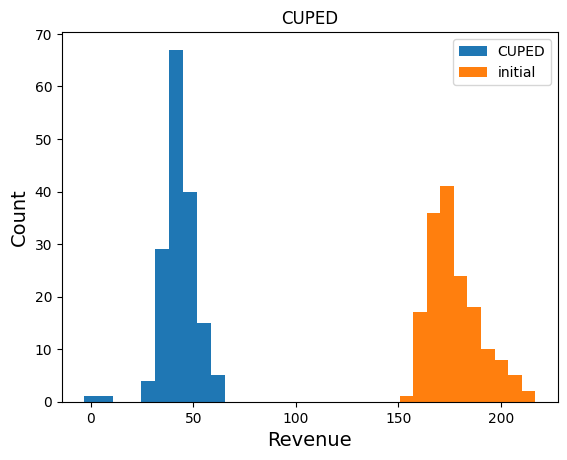

In [ ]:
data = pd.DataFrame({'metric_current_B': metric_current_B, 'metric_cuped_B': metric_cuped_B})
data['metric_current_B'] = data['metric_current_B'].astype(float)
data['metric_cuped_B'] = data['metric_cuped_B'].astype(float)
data.reset_index()
CUPED = data['metric_cuped_B']
initial = data['metric_current_B']

# Generate histogram plot
plt.hist(CUPED,
         label='CUPED')

plt.hist(initial,
         label='initial')

plt.legend(loc='upper right')
plt.title('CUPED')
plt.xlabel("Revenue", size=14)
plt.ylabel("Count", size=14)
plt.show()

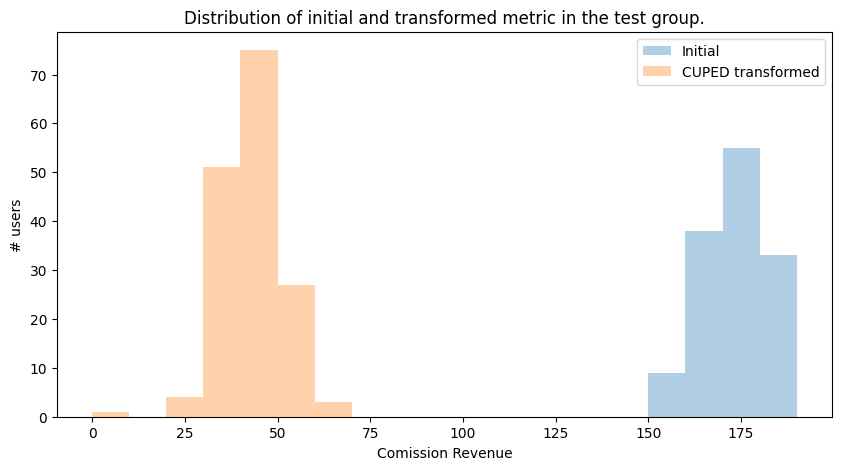

In [ ]:
plt.figure(figsize=(10, 5))

plt.hist(data['metric_current_B'],
         bins=np.arange(0.0, 200.0, 10.0),
         alpha=0.35,
         label='Initial')

plt.hist(data['metric_cuped_B'],
         bins=np.arange(0.0, 200.0, 10.0),
         alpha=0.35,
         label='CUPED transformed')

plt.legend()
plt.xlabel('Comission Revenue')
plt.ylabel('# users')
plt.title('Distribution of initial and transformed metric in the test group.')
plt.show()

Видим что наши выборки разошлись,что как раз вызвано изминениях в средних. Если изминить расчет CUPED метрик,выборки сойдуться и будет видна разница чистая разница до и после CUPED. "#metric_cuped_B = metric_current_B - thetta2 * (metric_past_B - np.mean(metric_past_B))"

По результат p val >0.05 при чем в случаях как с CUPED так и без. Что позволяет принять H0 . То что мы дали скидку и метрика не выросла. Т.е не зафикисровали с текущими параметрами A/B теста статистически значимый результат.

#Bootstrap

Бутстреп (bootstrap) - это метод для оценки стандартных отклонений и нахождения доверительных интервалов статистических функционалов. Допустим у нас маленькая выборка,то мы можем генерировать из имеющеющей выборки много раз выборки и сравнивать статистики. Мы генерируем из нашей выборки выборку сравниваем средние и повторяем процесс.

Основываеться на ЦПТ - сумма достаточно большого количества слабо зависимых случайных величин, имеющих примерно одинаковые масштабы (ни одно из слагаемых не доминирует, не вносит в сумму определяющего вклада), имеет распределение, близкое к нормальному. А наша выборка представляет собой часть генеральной совокупности.






In [ ]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len,
            replace = True # параметр возвращения
        ).values

        samples_2 = data_column_2.sample(
            boot_len,
            replace = True
        ).values

        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику

    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else:
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')

    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    return {"boot_data": boot_data,
            "quants": quants,
            "p_value": p_value}

Возьмем выборку 100n и представем что данных больше у нас нет.

In [ ]:
#a = pd.DataFrame(df['metric_0'].iloc[::100])
#b = pd.DataFrame(df['metric_1'].iloc[::100])

a = pd.DataFrame(np.random.choice(df['metric_0'], size=100, replace=False))
b = pd.DataFrame(np.random.choice(df['metric_1'], size=100, replace=False))

  0%|          | 0/10000 [00:00<?, ?it/s]

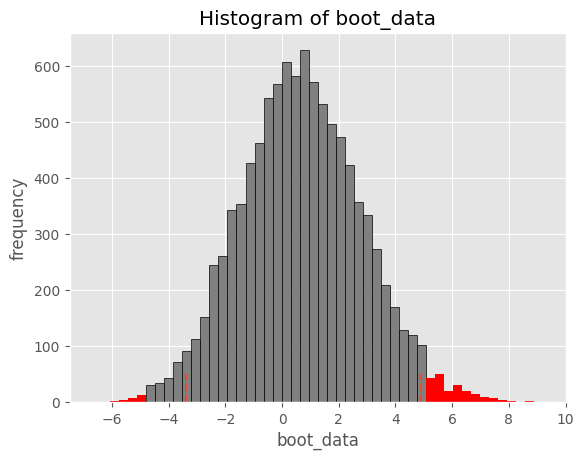

bootstrap mean p-values =  0.7474630695528262
0.6826219954781003


,0
0.025,-3.374857
0.975,4.917921


In [ ]:
booted_data = get_bootstrap(data_column_1=a, data_column_2=b)
print('bootstrap mean p-values = ' , booted_data['p_value'])
print(np.array(booted_data['boot_data']).mean())
booted_data['quants']

Доверительный интервал (ДИ) - это интервал, который покрывает оцениваемый параметр с заданной вероятностью. Вероятность следует понимать в том смысле, что если бы мы провели эксперимент множество раз, то в среднем для 95% доверительного интервала в 95 экспериментах из 100 истинный параметр принадлежал бы доверительному интервалу. Чтобы проверить гипотезу о равенстве квантилей на уровне значимости 5% достаточно построить 95% доверительный интервал для разности квантилей между группами. Средние, которые представляют собой 2.5 и 97.5 процентили. В нашем случае Нижняя граница квантиля - (-3.3) верхняя граница (4.9). Если ноль находится вне доверительного интервала, то отличия статистически значимы, иначе нет. Собственно об этом указывает p value > 0.05  



**Вывод**: провели стат. тест с параметрами 3% эффект,alpha = 0.05 power = 0.8 использовали сравнение обычного t test и методом снижения дисперсии t-test,а также bootstrap. В результате тестов p value оказалось выше 0.05, что позволяет принять H0-разницы нет.